# Мережа Кохонена

In [29]:
import numpy as np
import sys, math, time
import matplotlib.pyplot as plt


class SOM(object):
    def __init__(self):
        # Nothing here. The map instance content can be created by either 
        # loading from file or running the create method. 
        pass

    def create(self, width, height, ch):
        self.x = width  # Map width
        self.y = height  # Map height
        self.ch = ch # Map channels (vector length)
        self.trained = False

    def save(self, filename):
        # Save SOM to .npy file. 
        if self.trained:
            np.save(filename, self.node_vectors)
            return True
        else:
            return False

    def load(self, filename):
        # Load SOM from .npy file. 
        self.node_vectors = np.load(filename)
        self.x = self.node_vectors.shape[1]
        self.y = self.node_vectors.shape[0]
        self.ch = self.node_vectors.shape[2]
        self.trained = True
        return True

    def get_map_vectors(self):
        # Returns the map vectors. 
        if self.trained:
            return self.node_vectors
        else:
            return False
    
    def distance(self, vect_a, vect_b):
        if self.dist_method == 'euclidean':
            dist = np.linalg.norm(vect_a - vect_b)
        elif self.dist_method == 'cosine':
            dist = 1. - np.dot(vect_a, vect_b) / (np.linalg.norm(vect_a) * np.linalg.norm(vect_b))
        return dist
    
    def find_maching_nodes(self, input_arr):
        # This is to be called only when the map is trained.
        if self.trained == False:
            return False
        
        n_data = input_arr.shape[0]
        locations = np.zeros((n_data, 2), dtype=np.int32)   
        distances = np.zeros((n_data), dtype=np.float32)   
        
        print_step = int(n_data / 20)
        print_count = 0 
        for idx in range(n_data):
        
            if idx % print_step == 0: 
                print_count += 1
                sys.stdout.write(f'\rFinding mathing nodes' +
                 ' [' + '=' * (print_count) + '>' + '.' * (20 - print_count) + '] ')

            data_vect = input_arr[idx]
            min_dist = None
            x = None
            y = None
            for y_idx in range(self.y):
                for x_idx in range(self.x):
                    node_vect = self.node_vectors[y_idx, x_idx]
                    dist = self.distance(data_vect, node_vect)
                    if min_dist is None or min_dist > dist:
                        min_dist = dist
                        x = x_idx
                        y = y_idx            
            
            locations[idx, 0] = y
            locations[idx, 1] = x
            distances[idx] = min_dist

        print('Done')
        return locations, distances

    def initialize_map(self):
        # Initialize map weight vectors
        ds_mul = np.mean(self.input_arr) / 0.5
        self.node_vectors = np.random.rand(self.y, self.x, self.ch) * ds_mul

        
    def fit(self, input_arr, n_iter, batch_size=32, lr=0.25, random_sampling=1.0, 
            neighbor_dist=None, dist_method='euclidean'):
        self.input_arr = input_arr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.dist_method = dist_method
        
        start_time = time.time()
        self.initialize_map()

        # Learning rate. This defines how fast the node weights are updated. 
        self.lr = lr
        self.lr_decay = 0.8 # lr decay per iteration
        
        # Neighbor node coverage.
        # This tells that how far from the best matching node the 
        # other nodes are updated. 
        if neighbor_dist is None:
            neighbor_dist = min(self.x, self.y) / 1.3
        self.nb_dist = int(neighbor_dist) 
        
        # Rate of neighbor coverage reduction per iteration. 
        # Small values = fast decay. Large values = slow decay
        self.nb_decay = 1.5 
        
        # Pad the vector map to allow easy array processing. 
        tmp_node_vects = np.zeros((self.y + 2 * self.nb_dist, self.x + 2 * self.nb_dist, self.ch))
        tmp_node_vects[self.nb_dist : self.nb_dist + self.y, 
                       self.nb_dist : self.nb_dist + self.x] = self.node_vectors.copy()
        self.node_vectors = tmp_node_vects

        # Calculate number of data points per iteration. 
        # random_sampling can vary between 0 and 1. Together with index shuffling 
        # it can be used to randomly select fraction of data for each iteration 
        # to speed up the training. 
        if random_sampling > 1 or random_sampling <= 0:
            random_sampling = 1
        n_data_pts = int(self.input_arr.shape[0] * random_sampling)


        data_idx_arr = np.arange(self.input_arr.shape[0])
        batch_count = math.ceil(n_data_pts / self.batch_size)
        n_per_report_step = int(n_data_pts / 20)
        
        # Main iteration loop. One iteration means that all data is 
        # used once to train the map weights. 
        for iteration in range(self.n_iter):
            
            # Update the neighbor function. Typically the neighbor coverage
            # reduces with increasing iteration number
            self.make_neighbor_function(iteration)

            # Shuffle the data indexes. 
            np.random.shuffle(data_idx_arr)
            
            # Temporary variables
            total_dist = 0 
            total_count = 0
            print_count = 0
            
            # Batch processing loop. The map weight update is done at the end of 
            # each batch. Often the batch size is e.g. some tens of data samples. 
            # Too large batch size can lead to convergence problems. 
            for batch in range(batch_count): 
                
                # Calculate steps (data points) for this batch
                steps_left = n_data_pts - batch * self.batch_size
                if steps_left < self.batch_size:
                    steps_in_batch = steps_left
                else:
                    steps_in_batch = self.batch_size
                
                # Create array for storing the best matching node indexes 
                bm_node_idx_arr = np.zeros((steps_in_batch, 3), dtype=np.int32)

                # Process each input data point in this batch
                for step in range(steps_in_batch):
                    
                    # Print progress update on the screen
                    if total_count % n_per_report_step == 0: 
                        print_count += 1
                        sys.stdout.write(f'\rProcessing SOM iteration {iteration + 1}/{self.n_iter}' +\
                                 ' [' + '=' * (print_count) + '>' + '.' * (20 - print_count) + ']')
                    total_count += 1

                    # Get the input data and calculate distance to the best matching node in the map
                    input_idx = data_idx_arr[batch * self.batch_size + step]
                    input_vect = self.input_arr[input_idx]
                    y, x, dist = self.find_best_matching_node(input_vect)
                    bm_node_idx_arr[step, 0] = y
                    bm_node_idx_arr[step, 1] = x
                    bm_node_idx_arr[step, 2] = input_idx 
                    total_dist += dist
                
                # Update the map weights at the end of the batch
                self.update_node_vectors(bm_node_idx_arr)
                
            # Print the average input data distance to the best matching node in the map.  
            print(f' Average distance = {total_dist / n_data_pts:0.5f}')
            
            # Update the learnig rate 
            self.lr *= self.lr_decay
            
        # Remove padding from the vector map
        self.node_vectors = self.node_vectors[self.nb_dist : self.nb_dist + self.y, 
                                              self.nb_dist : self.nb_dist + self.x]
        
        # Delete the input data array from the map instance
        del self.input_arr

        end_time = time.time()
        self.trained = True
        print(f'Training done in {end_time - start_time:0.6f} seconds.')
            
    def update_node_vectors(self, bm_node_idx_arr):
        # This method updates the map node weights. 
        # Input is one batch of best matching node coordinates and indexes to corresponsing 
        # data array locations. 
        
        for idx in range(bm_node_idx_arr.shape[0]):
            node_y = bm_node_idx_arr[idx, 0]
            node_x = bm_node_idx_arr[idx, 1]
            inp_idx = bm_node_idx_arr[idx, 2]
            input_vect = self.input_arr[inp_idx]
            
            old_coeffs = self.node_vectors[node_y + self.y_delta + self.nb_dist, node_x + self.x_delta + self.nb_dist]
            
            update_vect = self.nb_weights * self.lr * (np.expand_dims(input_vect, axis=0) - old_coeffs)
            
            self.node_vectors[node_y + self.y_delta + self.nb_dist, 
                              node_x + self.x_delta + self.nb_dist, :] += update_vect
              
    def find_best_matching_node(self, data_vect):
        # This method is used to find best matching node for data vector. 
        # The node coordinates and distance are returned. 
        # This can be used only by the fit process since this assumes that the map is 
        # padded. 
        
        min_dist = None
        x = None
        y = None
        for y_idx in range(self.y):
            for x_idx in range(self.x):
                node_vect = self.node_vectors[y_idx + self.nb_dist, x_idx + self.nb_dist]
                dist = self.distance(data_vect, node_vect)
                if min_dist is None or min_dist > dist:
                    min_dist = dist
                    x = x_idx
                    y = y_idx
                
        return y, x, min_dist
                
         
    def make_neighbor_function(self, iteration):
        # This method creates Gaussian 'bell' shaped 3D weight array in that is 
        # stored in 2D arrays. There is own array for x coordinates, y coordinates and 
        # for the weight values. The coordinate zero point is at the center of the Gaussian curve.
        # The bell width reduces when iteration value increases. 
        
        size = self.nb_dist * 2
        sigma = size / (7 + iteration / self.nb_decay)
        self.nb_weights = np.full((size * size, self.ch), 0.0)
        cp = size / 2.0 
        p1 = 1.0 / (2 * math.pi * sigma ** 2) 
        pdiv = 2.0 * sigma ** 2
        y_delta = []
        x_delta = []
        for y in range(size):
            for x in range(size):
                ep = -1.0 * ((x - cp) ** 2.0 + (y - cp) ** 2.0) / pdiv
                value = p1 * math.e ** ep
                self.nb_weights[y * size + x] = value
                y_delta.append(y - int(cp))
                x_delta.append(x - int(cp))
        self.x_delta = np.array(x_delta, dtype=np.int32)
        self.y_delta = np.array(y_delta, dtype=np.int32)

        self.nb_weights -= self.nb_weights[size // 2]
        self.nb_weights[self.nb_weights < 0] = 0 
        self.nb_weights /= np.max(self.nb_weights)  

        
    def get_umatrix(self):
        # This method creates a map of average vector distances from each node to the nodes 
        # above, below, left and right. 

        if not self.trained:
            return False

        umatrix = np.zeros((self.y, self.x))
        
        for map_y in range(self.y):
            for map_x in range(self.x):                

                n_dist = 0 
                total_dist = 0
                
                if map_y > 0: 
                    dist_up = self.distance(self.node_vectors[map_y, map_x], 
                                            self.node_vectors[map_y - 1, map_x])
                    total_dist += dist_up 
                    n_dist += 1

                if map_y < self.y - 1: 
                    dist_down = self.distance(self.node_vectors[map_y, map_x], 
                                              self.node_vectors[map_y + 1, map_x])
                    total_dist += dist_down 
                    n_dist += 1

                if map_x > 0: 
                    dist_left = self.distance(self.node_vectors[map_y, map_x], 
                                              self.node_vectors[map_y, map_x - 1])
                    total_dist += dist_left
                    n_dist += 1
                    
                if map_x < self.x - 1: 
                    dist_right = self.distance(self.node_vectors[map_y, map_x], 
                                               self.node_vectors[map_y, map_x + 1])
                    total_dist += dist_right
                    n_dist += 1

                avg_dist = total_dist / n_dist
                umatrix[map_y, map_x] = avg_dist
                
        return umatrix 
    

    def get_component_plane(self, component):
        if not self.trained:
            return False
        cplane = self.node_vectors[:, :, component].copy()
        return cplane


def plot_data_on_map(umatrix, data_locations, data_colors, data_labels=None,
                        node_width=20,
                        node_edge_color=0,
                        data_marker_size=100,
                        invert_umatrix=True,
                        plot_labels=False,
                        dpi=100):
    
    map_x = umatrix.shape[1]
    map_y = umatrix.shape[0]
    canvas = np.zeros((map_y * node_width, map_x * node_width))
    
    tmp_umatrix = umatrix.copy()
    tmp_umatrix -= np.min(tmp_umatrix)
    tmp_umatrix /= np.max(tmp_umatrix)
    
    if invert_umatrix:
        tmp_umatrix = 1 - tmp_umatrix

    for y in range(map_y):
        for x in range(map_x):
            canvas[y * node_width : (y + 1) * node_width, 
                   x * node_width : (x + 1) * node_width] = tmp_umatrix[y, x]
    
    if not node_edge_color is None:
        # Draw node borders
        for y in range(map_y):
            canvas[y * node_width, :] = node_edge_color  

        for x in range(map_x):
            canvas[:, x * node_width] = node_edge_color  
   
    # Plot the SOM u-matrix as background 
    plt.figure(figsize=(map_x * node_width / dpi, map_y * node_width / dpi), dpi=dpi)
    plt.imshow(canvas, cmap='gray', interpolation='hanning')

    # Initialize some temp variables
    item_count_map = np.zeros(umatrix.shape) 
    n_data_pts = data_locations.shape[0]

    for i in range(n_data_pts):

        x = data_locations[i, 1]
        y = data_locations[i, 0]
        items_in_cell = item_count_map[y, x]
        item_count_map[y, x] += 1
        x = x * node_width + node_width // 2 + items_in_cell * 5
        y = y * node_width + node_width // 2 + items_in_cell * 5
        plt.scatter(x, y, s=data_marker_size, color=data_colors[i], edgecolors=[0,0,0])
        
        if plot_labels:
            plt.annotate(str(data_labels[i]), (x + 8, y), size='small')

        plt.axis('off')
        
    filename = 'SOM_mapping_' + str(int(time.time())) + '.png'
    plt.savefig(filename)
    plt.show()
    print(f'Image saved to {filename}')
 

In [30]:
data = [[3.0, -0.1, 4.3, 4.6, 8.5, 1.8, 8.3, 2.5, 0.2, 4.6, 4.5, 8.5, 2.2, 8.2, 2.7, 0.2, 4.4, 4.6, 8.3, 2.0, 8.5, 2.7, 0.1, 4.3, 4.7, 8.5, 2.1, 8.3],
       [1.0, 3.7, 4.4, 2.3, 2.7, 3.3, -0.1, 1.2, 3.6, 4.7, 2.3, 2.9, 3.2, 0.1, 0.8, 4.0, 4.5, 2.2, 2.4, 3.3, 0.0, 0.9, 4.0, 4.4, 1.9, 2.5, 3.5, -0.3]]


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random, time, sys, math
from mpl_toolkits.mplot3d import Axes3D

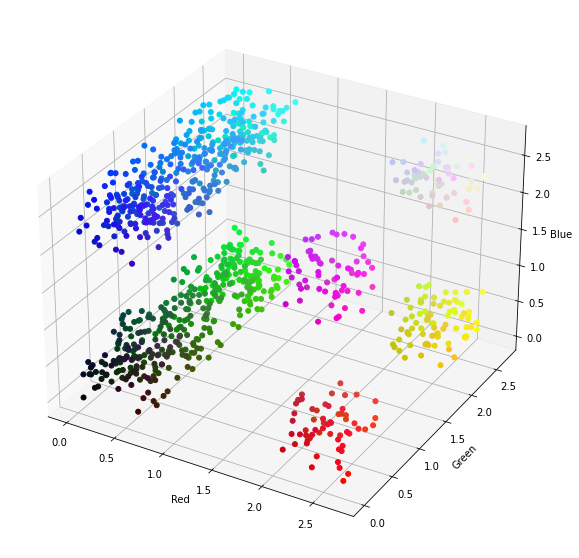

In [34]:
# Generate the data
dataset = np.random.randint(0, 2, size=(1000, 3)).astype(np.float32) * 2
dataset[:500, 1] = np.linspace(0, 2, 500)
dataset[:500, 0] = 0
dataset += np.random.rand(1000, 3) * .7

# Create the colors for the vectors and scale the values to [0, 1]
colors = dataset.copy()
colors -= np.min(colors)
colors /= np.max(colors)

# Slice the dataset to three axes for 3D plotting
reds = dataset[:, 0]
greens = dataset[:, 1] 
blues = dataset[:, 2]

# Plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(reds, greens, blues, c=colors, alpha=1, s=100, marker='.')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

In [35]:
# Create the SOM instance.
som = SOM()
som.create(width=13, height=13, ch=3)

# Fit the map to the dataset using total 20 optimization rounds.
som.fit(dataset, random_sampling=0.5, n_iter=20, dist_method='euclidean')

Processing SOM iteration 1/20 [====================>] Average distance = 0.53800
Processing SOM iteration 2/20 [====================>] Average distance = 0.43673
Processing SOM iteration 3/20 [====================>] Average distance = 0.41018
Processing SOM iteration 4/20 [====================>] Average distance = 0.35390
Processing SOM iteration 5/20 [====================>] Average distance = 0.34729
Processing SOM iteration 6/20 [====================>] Average distance = 0.32260
Processing SOM iteration 7/20 [====================>] Average distance = 0.30401
Processing SOM iteration 8/20 [====================>] Average distance = 0.28450
Processing SOM iteration 9/20 [====================>] Average distance = 0.26875
Processing SOM iteration 10/20 [====================>] Average distance = 0.26090
Processing SOM iteration 11/20 [====================>] Average distance = 0.24878
Processing SOM iteration 12/20 [====================>] Average distance = 0.24341
Processing SOM iteration 

In [36]:
data_locations, vect_distances = som.find_maching_nodes(dataset)

Finding mathing nodes [====================>] Done


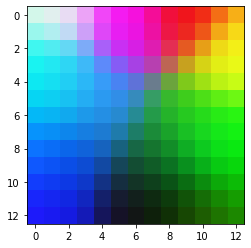

In [37]:
map_vectors = som.get_map_vectors().copy()

# Scale the values to [0, 1]
map_vectors -= np.min(map_vectors)
map_vectors /= np.max(map_vectors)
plt.imshow(map_vectors)
plt.show()

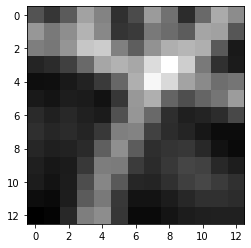

In [38]:
umatrix = som.get_umatrix()
plt.imshow(umatrix, cmap='gray')

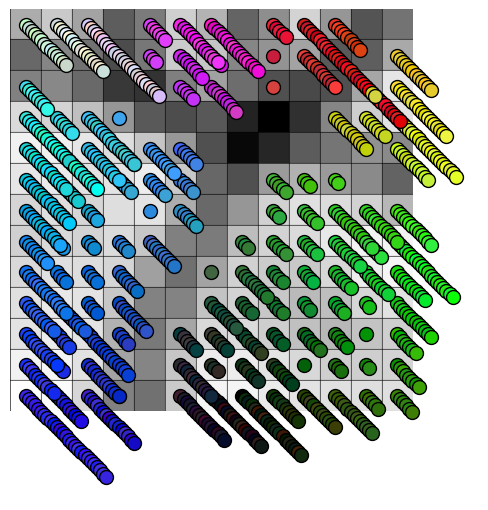

Image saved to SOM_mapping_1717021073.png


In [39]:
# Define colors for the data points. In this case we just scale the values to [0, 1]
colors = dataset.copy()
colors -= np.min(colors)
colors /= np.max(colors)

plot_data_on_map(umatrix, data_locations, data_colors=colors, 
                 node_width=50, data_marker_size=100)     

2024-05-30 01:18:01,177 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-05-30 01:18:01,177 - DEBUG - findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2024-05-30 01:18:01,178 - DEBUG - findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-05-30 01:18:01,179 - DEBUG - findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-05-30 01:18:01,179 - DEBUG - findfont: score(FontEntry(fname='/usr/share/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='c

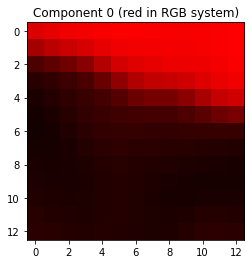

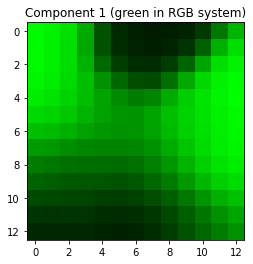

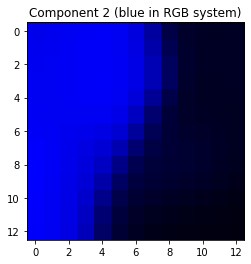

In [40]:
# Define plot colors for the component planes
colors = {0 : 'red', 1 : 'green', 2 : 'blue'}

# Plot the component planes
for i in range(3):
    cplane = som.get_component_plane(i)
    img = np.zeros(cplane.shape + (3,))
    img[:, :, i] = cplane
    img -= np.min(img)
    img /= np.max(img)
    plt.imshow(img)
    plt.title(f'Component {i} ({colors[i]} in RGB system)' )
    plt.show()

# Мережа Хопфілда

In [42]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

class HopfieldNetwork(object):      
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        
        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        # Copy to avoid call by reference 
        copied_data = np.copy(data)
        
        # Define predict list
        predicted = []
        for i in tqdm(range(len(data))):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        if self.asyn==False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                for j in range(100):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron) 
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()

Start to data preprocessing...
Start to train weights...


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1269.27it/s]


Start to predict...


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 43.98it/s]

Show prediction results...


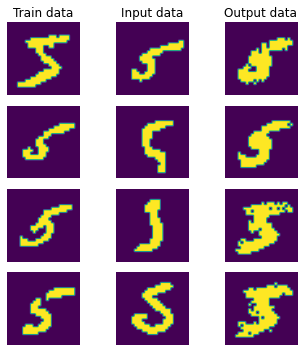

2024-05-30 01:37:29,962 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f34b86f44f0>


Show network weights matrix...


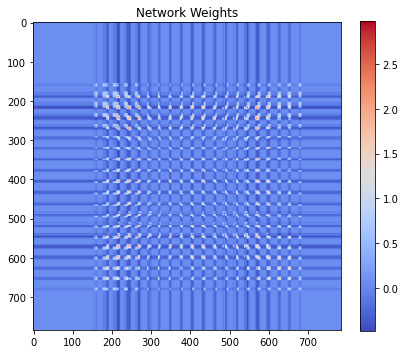

In [56]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_mean
from keras.datasets import mnist

# Utils
def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(3, 3)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    
    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')
            
        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')
            
    plt.tight_layout()
    plt.savefig("result_mnist.png")
    plt.show()

def preprocessing(img):
    w, h = img.shape
    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int
    
    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    rng = 4
    selected_number = 5
    # Load data
    (x_train, y_train), (_, _ )= mnist.load_data()
    data = []
    for i in range(rng):
        xi = x_train[y_train==selected_number]
        data.append(xi[i])
    
    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    
    # Create Hopfield Network Model
    model = HopfieldNetwork()
    model.train_weights(data)
    
    # Make test datalist
    test = []
    for i in range(rng):
        xi = x_train[y_train==selected_number]
        test.append(xi[rng+i])
    test = [preprocessing(d) for d in test]
    
    predicted = model.predict(test, threshold=50, asyn=True)
    print("Show prediction results...")
    plot(data, test, predicted, figsize=(5, 5))
    print("Show network weights matrix...")
    model.plot_weights()
    
if __name__ == '__main__':
    main()